# Comparing ALCS Latent-Learning capabilities

Approach to compare *latent-learning* capabilities of various ALCS systems.

The following aspects will be compared:

- ability learn consequences of performing action in certain states (build accurate internal model of the environment),
- ability to generalize,
- size of internal classifier population,
- relative operation time

In [1]:
import os
import pathlib
import dill
import random

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt


from lcs import Perception
from lcs.agents import EnvironmentAdapter

import gym


# Logger
# import logging
# logging.basicConfig(level=logging.DEBUG)

# Common plot settings
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['lines.linewidth'] = 2

# Gecco submission settings
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2

In [2]:
# Import common utils code
%run utils/experiments.py
%run utils/plotting.py

In [3]:
# Cache function result into file (no-need for recomputation)
def get_from_cache_or_run(cache_path, fun):
    os.makedirs(os.path.dirname(cache_path), exist_ok=True)

    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            return dill.load(f)
    else:
        res = fun()

        # save the results to file
        with open(cache_path, 'wb') as f:
            dill.dump(res, f)

        return res
    
cache_prefix = f'{pathlib.Path().absolute()}/cache/'
cache_prefix

'/home/arc/Projects/pwr/pyalcs-experiments/alcs_comparison/cache/'

# Environments
This section presents the multi-step environments that were used in experiments.

1. [Simple Maze](#Simple-Maze) - Simpler maze variant with limited perception and available actions

Discretized real-valued.

2. [Corridor](#Corridor) - one dimension and two actions are available. The agent is checked is optimal number of classifiers is created
3. [Grid](#Grid) - two dimensions and four actions.

Maybe (todo)

4. Maze4 / Maze6 - More advanced mazes (bigger perception and available actions)

## Simple Maze
In each trial the agent is placed in __S__ tile. It can perceive 4 values (N, E, S and W) and can move in each cardinal direction. The trial ends when tile **F** is reached.

![simple-maze](img/simple-maze.png)

Minimal number of classifiers to model the environment is __20__. The number of _"fully-specialized"_ classifiers is **32**.

In [4]:
import gym_yacs_simple_maze

simple_maze = gym.make('SimpleMaze-v0')
simple_maze_perceptions = simple_maze.env.PERCEPTIONS
simple_maze_transitions = simple_maze.env.TRANSITIONS

# LCS helpers
def simple_maze_knowledge(pop, env):
    all_transitions = 0
    nr_correct = 0

    for s0, action_states in env.env.TRANSITIONS.items():
        for action_state in action_states:
            all_transitions += 1

            action = action_state.action.value
            s1 = action_state.state

            p0 = env.env._perception(s0)
            p1 = env.env._perception(s1)
            
            if any([True for cl in pop if cl.predicts_successfully(p0, action, p1)]):
                nr_correct += 1
            
    return nr_correct / all_transitions

def simple_maze_metrics_collect(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': simple_maze_knowledge(population, env),
        'generalization': generalization_score(population)
    }

# DynaQ helpers
def simple_maze_perception_to_int(p0):
    p0m = list(map(int, p0))
    return list(simple_maze_perceptions.keys())[list(simple_maze_perceptions.values()).index(p0m)]

def simple_maze_knowledge_calculator(model, env):
    all_transitions = 0
    nr_correct = 0

    for s0, moves in simple_maze_transitions.items():
        for move in moves:
            a = move.action.value
            s1 = move.state
            
            all_transitions += 1
            if s0 in model and a in model[s0] and model[s0][a][0] == s1:
                nr_correct += 1

    return nr_correct / all_transitions

In [5]:
%%time


common_params = {
    'env': simple_maze,
    'classifier_length': 4,
    'possible_actions': 4,
    'learning_rate': 0.1,
    'environment_adapter': EnvironmentAdapter,
    'metrics_trial_freq': 1,
    'metrics_fcn': simple_maze_metrics_collect,
    'explore_trials': 250
}

yacs_params = {
    'trace_length': 3,
    'feature_possible_values': [2, 2, 2, 2]
}

dynaq_params = {
    'num_states': len(simple_maze_perceptions),
    'perception_to_state_mapper': simple_maze_perception_to_int,
    'knowledge_fcn': simple_maze_knowledge_calculator
}

simple_maze_metrics = get_from_cache_or_run(
    f'{cache_prefix}/SimpleMaze-metrics.dill', 
    lambda: avg_experiments(lambda: run_experiment(common_params, yacs_params=yacs_params, dynaq_params=dynaq_params), n=50))

simple_maze_metrics

CPU times: user 324 µs, sys: 2.76 ms, total: 3.08 ms
Wall time: 2.23 ms


time  knowledge  population  generalization  trial_steps
agent trial                                                              
acs   0      0.019128   0.660000       14.70        0.604907          NaN
      1      0.015605   0.741333       16.46        0.579481          NaN
      2      0.019672   0.773333       17.30        0.562400          NaN
      3      0.019420   0.802667       18.02        0.550652          NaN
      4      0.023347   0.825333       18.46        0.546229          NaN
...               ...        ...         ...             ...          ...
yacs  245    0.048549   0.984000       37.30        0.306702          NaN
      246    0.069122   0.981333       37.38        0.306835          NaN
      247    0.052676   0.978667       37.44        0.306644          NaN
      248    0.048109   0.989333       37.42        0.306835          NaN
      249    0.048895   0.986667       37.46        0.307011          NaN

[1250 rows x 5 columns]

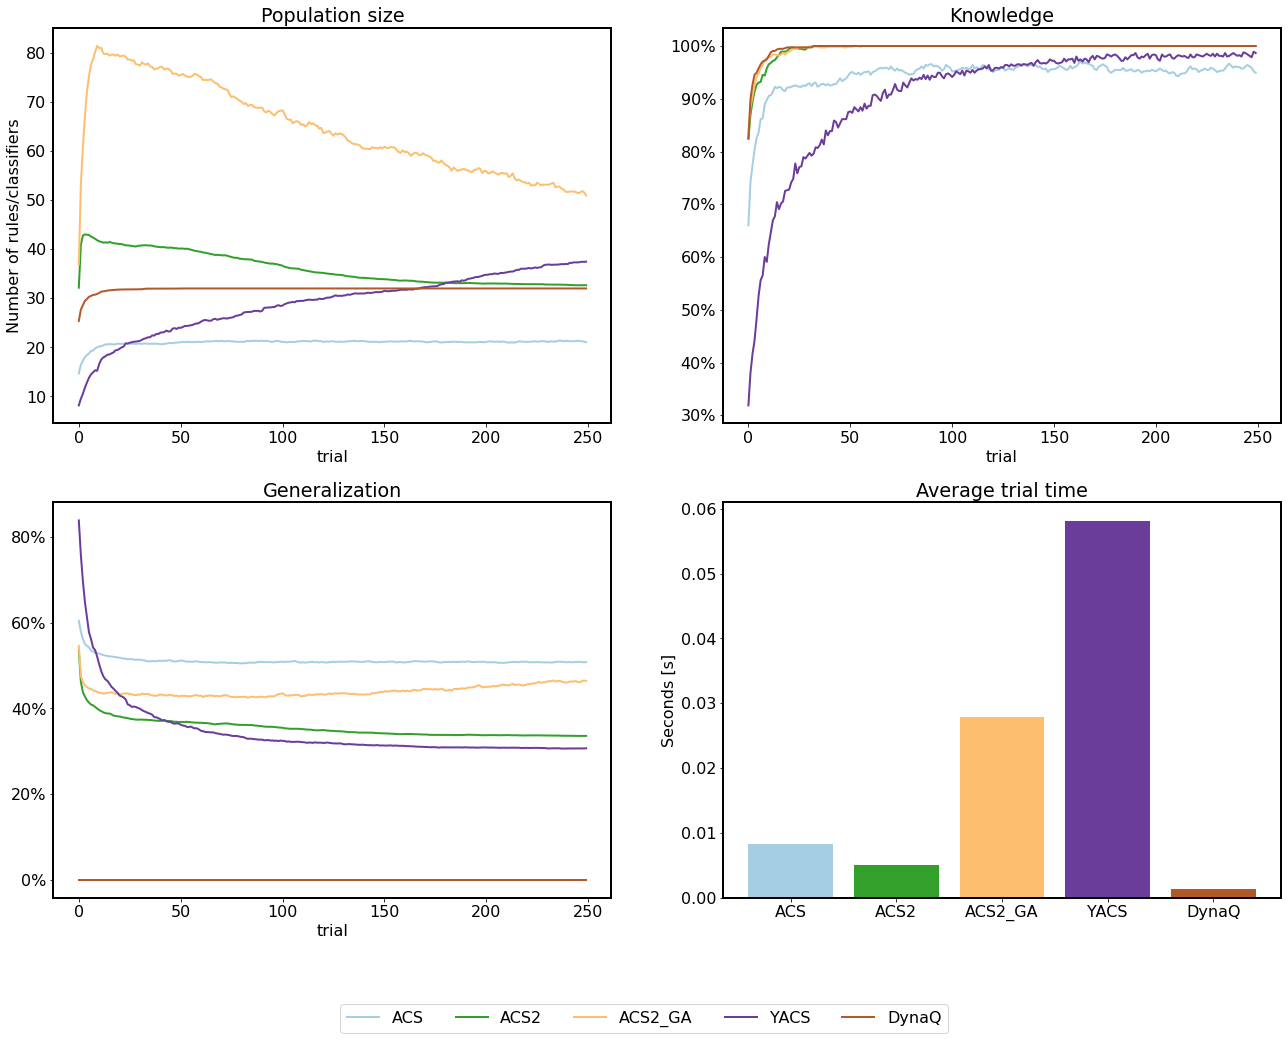

In [6]:
plot_comparison(simple_maze_metrics)
plt.savefig('plots/simple-maze.pdf', transparent=False, bbox_inches='tight')

## Corridor

![corridor](img/corridor.png)

In [7]:
import gym_corridor

corridor = gym.make('corridor-20-v0')

# LCS helpers
def corridor_knowledge(pop, env):
    transitions = env.env.get_transitions()
    reliable = [c for c in pop if c.is_reliable()]
    nr_correct = 0

    for start, action, end in transitions:
        p0 = Perception((str(start),))
        p1 = Perception((str(end),))

        if any(
            [True for cl in reliable if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1

    return nr_correct / len(transitions)


def corridor_metrics_collect(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': corridor_knowledge(population, env),
        'generalization': generalization_score(population)
    }


class CorridorAdapter(EnvironmentAdapter):
    @staticmethod
    def to_genotype(phenotype):
        return [str(phenotype)]


# DynaQ helpers
def dynaq_corridor_knowledge_calculator(model, env):
    transitions = env.env.get_transitions()
    nr_correct = 0

    for (s0, a, s1) in transitions:
        if s0 in model and a in model[s0] and model[s0][a][0] == s1:
            nr_correct += 1

    return nr_correct / len(transitions)

In [8]:
%%time

common_params = {
    'env': corridor,
    'classifier_length': 1,
    'possible_actions': 2,
    'learning_rate': 0.1,
    'environment_adapter': CorridorAdapter,
    'metrics_trial_freq': 1,
    'metrics_fcn': corridor_metrics_collect,
    'explore_trials': 300
}

yacs_params = {
    'trace_length': 3,
    'feature_possible_values': [19]
}

dynaq_params = {
    'num_states': corridor.env.observation_space.n,
    'perception_to_state_mapper': lambda p: int(p),
    'knowledge_fcn': dynaq_corridor_knowledge_calculator
}

corridor_metrics = get_from_cache_or_run(
    f'{cache_prefix}/Corridor-metrics.dill', 
    lambda: avg_experiments(lambda: run_experiment(common_params, yacs_params=yacs_params, dynaq_params=dynaq_params), n=50))

corridor_metrics

CPU times: user 1.58 ms, sys: 346 µs, total: 1.92 ms
Wall time: 1.39 ms


time  knowledge  population  generalization  trial_steps
agent trial                                                              
acs   0      0.012071   0.037297       26.18        0.089293          NaN
      1      0.007170   0.063243       29.90        0.072436          NaN
      2      0.005863   0.077838       32.16        0.064331          NaN
      3      0.004358   0.087027       33.46        0.060608          NaN
      4      0.004179   0.090811       34.18        0.059306          NaN
...               ...        ...         ...             ...          ...
yacs  295    0.050413   1.000000       38.00        0.000000          NaN
      296    0.051422   1.000000       38.00        0.000000          NaN
      297    0.056659   1.000000       38.00        0.000000          NaN
      298    0.051990   1.000000       38.00        0.000000          NaN
      299    0.058925   1.000000       38.00        0.000000          NaN

[1500 rows x 5 columns]

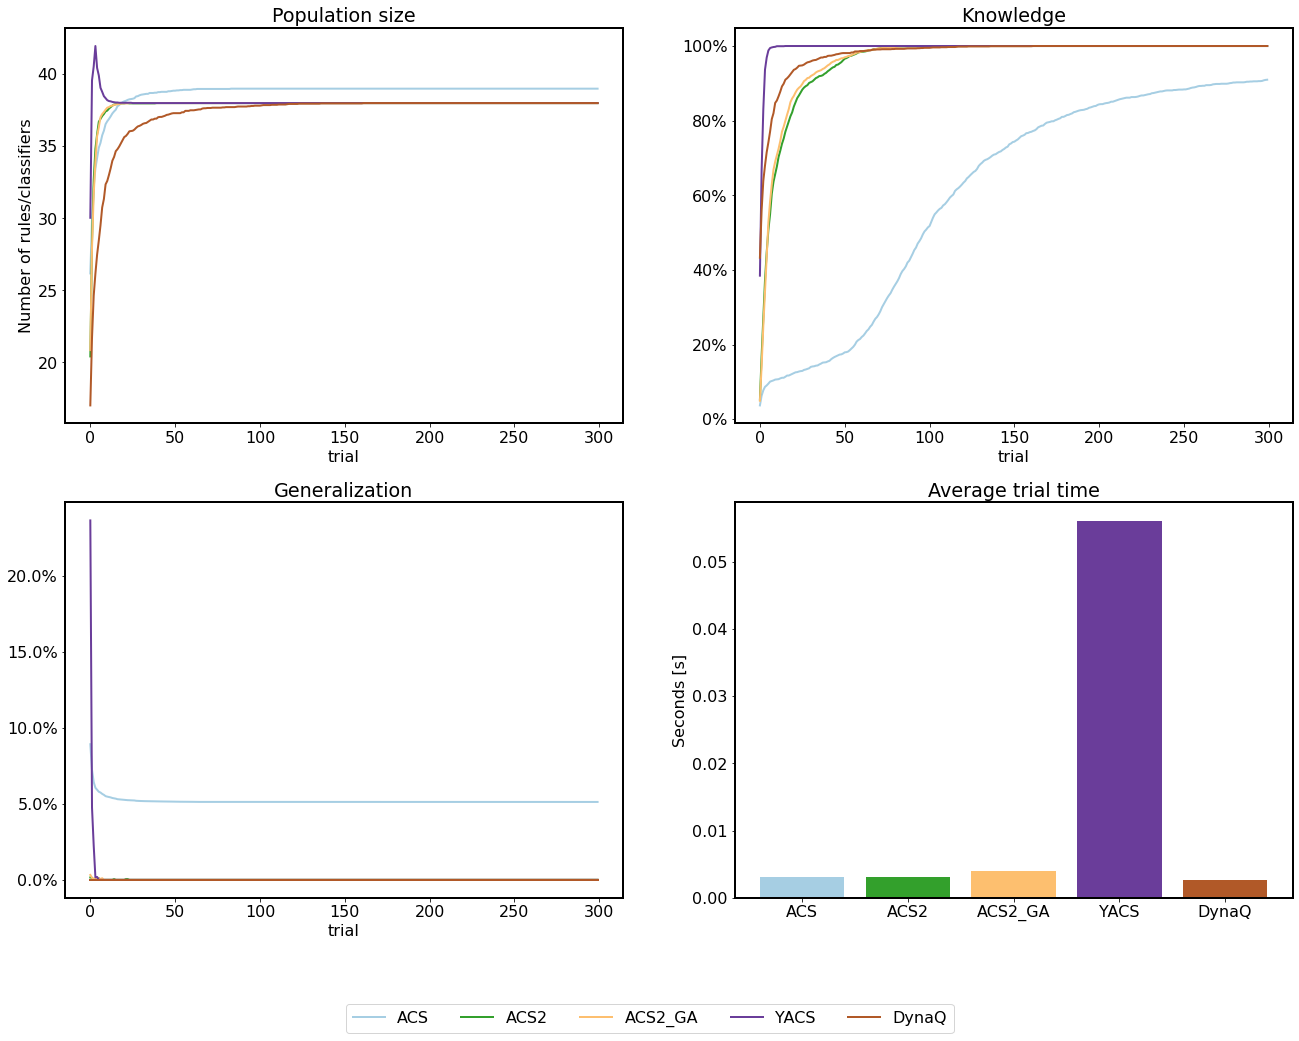

In [9]:
plot_comparison(corridor_metrics)
plt.savefig('plots/corridor.pdf', transparent=False, bbox_inches='tight')

## Grid
![grid](img/grid.png)

In [10]:
import gym_grid

grid = gym.make('grid-20-v0')
grid_transitions = grid.env._transitions

unique_states = set()
for (s0, a, s1) in grid_transitions:
    unique_states.add(s0)
    unique_states.add(s1)

grid_state_mapping = {idx: s for idx, s in enumerate(unique_states)}


# LCS helpers
def grid_knowledge(population, env):
    transitions = env.env.get_transitions()
    reliable = [c for c in population if c.is_reliable()]
    nr_correct = 0
    
    for start, action, end in transitions:
        p0 = Perception([str(el) for el in start])
        p1 = Perception([str(el) for el in end])
        
        if any([True for cl in reliable if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1
    
    return nr_correct / len(transitions)

def grid_metrics_collector(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': grid_knowledge(population, env),
        'generalization': generalization_score(population)
    }

# DynaQ helpers
def grid_perception_to_int(p0):
    p0m = tuple(map(int, p0))
    return list(grid_state_mapping.keys())[list(grid_state_mapping.values()).index(p0m)]

def dynaq_grid_knowledge_calculator(model, env):
    all_transitions = 0
    nr_correct = 0

    for p0, a, p1 in grid_transitions:
        s0 = grid_perception_to_int(p0)
        s1 = grid_perception_to_int(p1)

        all_transitions += 1
        if s0 in model and a in model[s0] and model[s0][a][0] == s1:
            nr_correct += 1

    return nr_correct / all_transitions

In [11]:
%%time

common_params = {
    'env': grid,
    'classifier_length': 2,
    'possible_actions': 4,
    'learning_rate': 0.1,
    'environment_adapter': EnvironmentAdapter,
    'metrics_trial_freq': 1,
    'metrics_fcn': grid_metrics_collector,
    'explore_trials': 250
}

yacs_params = {
    'trace_length': 3,
    'feature_possible_values': [20, 20]
}

dynaq_params = {
    'num_states': len(grid_state_mapping),
    'perception_to_state_mapper': grid_perception_to_int,
    'knowledge_fcn': dynaq_grid_knowledge_calculator
}

grid_metrics = get_from_cache_or_run(
    f'{cache_prefix}/Grid-metrics.dill', 
    lambda: avg_experiments(lambda: run_experiment(common_params, yacs_params=yacs_params, dynaq_params=dynaq_params), n=5))

grid_metrics

CPU times: user 1.21 ms, sys: 208 µs, total: 1.42 ms
Wall time: 1.16 ms


time  knowledge  population  generalization  trial_steps
agent trial                                                              
acs   0      0.226921   0.152569        64.4        0.531181          NaN
      1      0.255180   0.276153        71.8        0.528092          NaN
      2      0.225455   0.365744        74.0        0.527059          NaN
      3      0.238622   0.431489        74.8        0.526752          NaN
      4      0.281038   0.531489        75.6        0.526460          NaN
...               ...        ...         ...             ...          ...
yacs  245    6.331622   0.962187       376.0        0.310487          NaN
      246    7.111329   0.962187       376.0        0.310487          NaN
      247    6.947625   0.962187       376.0        0.310487          NaN
      248    3.713653   0.962187       376.0        0.310487          NaN
      249    4.712107   0.962187       376.0        0.310487          NaN

[1250 rows x 5 columns]

In [12]:
# grid_metrics.loc['acs2']

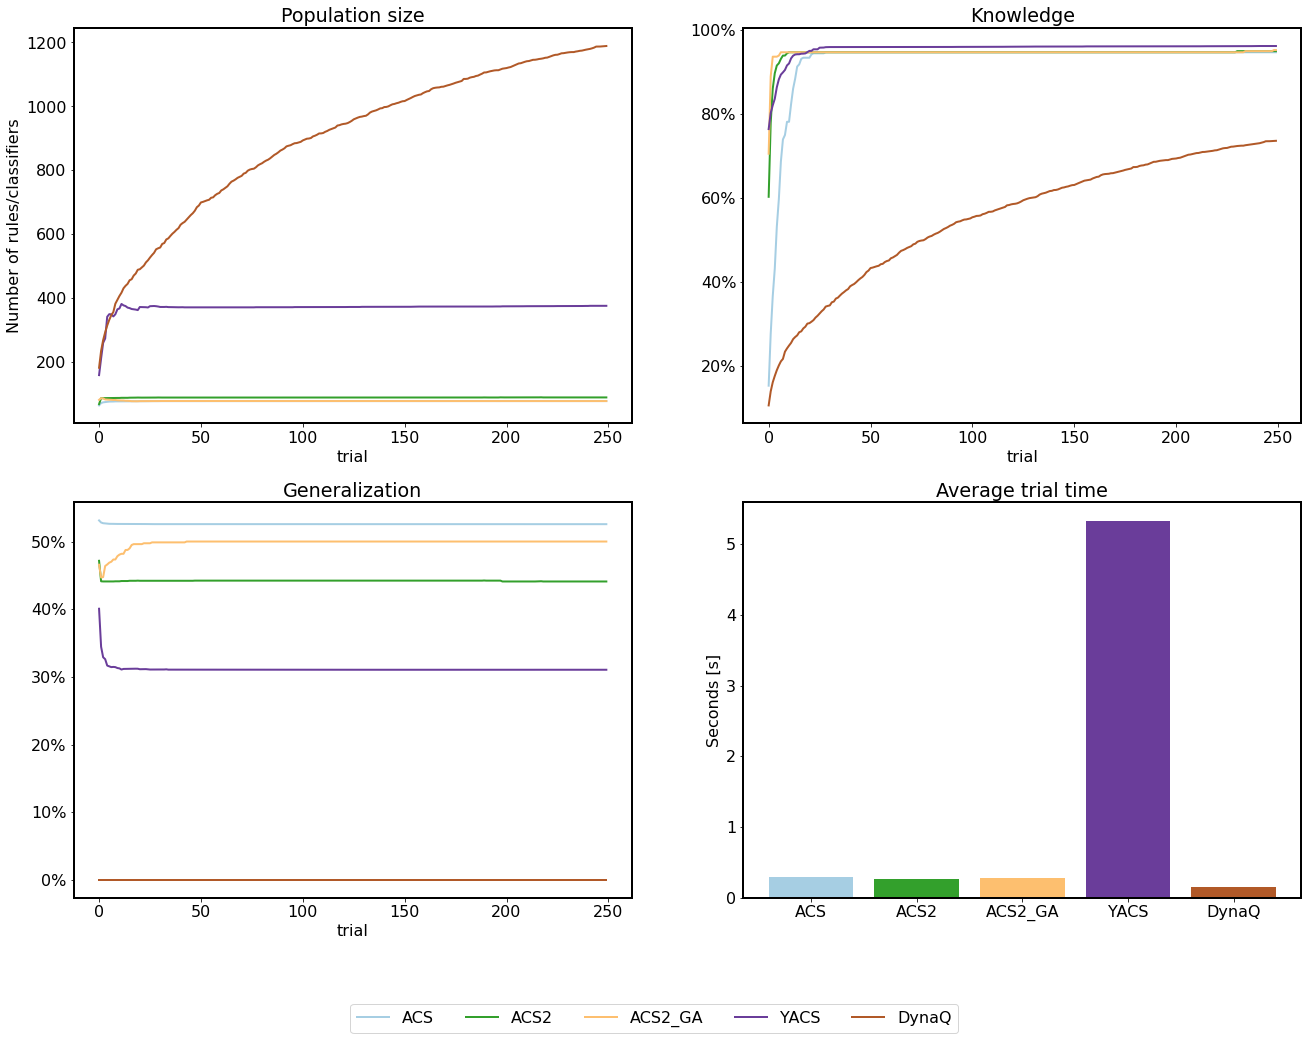

In [13]:
plot_comparison(grid_metrics)
plt.savefig('plots/grid.pdf', transparent=False, bbox_inches='tight')

## Conclusions

First obvious points:
- YACS is over-specialising and slow,
- YACS handles big dimensions (Grid environment) poorly